# Control moment gyroscope

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from numpy import linalg
from scipy import signal

# This is my own script (it is an interface to the pybullet simulator)
import ae353_cmg

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_cmg)

<module 'ae353_cmg' from 'C:\\Users\\david\\Documents\\uiuc\\ae353\\ae353-sp22\\projects\\01_cmg\\ae353_cmg.py'>

In [2]:
from sympy.physics import mechanics
mechanics.init_vprinting()

Define parameters in symbolic form.

In [3]:
# Principal moments of inertia
J_1x, J_1y, J_1z = sym.symbols('J_1x, J_1y, J_1z')
J_2x, J_2y, J_2z = sym.symbols('J_2x, J_2y, J_2z')
J_3x, J_3y, J_3z = sym.symbols('J_3x, J_3y, J_3z')

# Moment of inertia matrices in body-fixed reference frames
J1 = sym.Matrix.diag(J_1x, J_1y, J_1z)
J2 = sym.Matrix.diag(J_2x, J_2y, J_2z)
J3 = sym.Matrix.diag(J_3x, J_3y, J_3z)

# Spar length
r = sym.symbols('r')

# Load mass
m = sym.symbols('m')

# Acceleration of gravity
g = sym.symbols('g')

In [4]:
# Time
t = sym.Symbol('t')

# Joint angles:
q1, q2, q3 = mechanics.dynamicsymbols('q1, q2, q3')

# Joint velocities
v1 = q1.diff(t)
v2 = q2.diff(t)
v3 = q3.diff(t)

# Joint accelerations
a1 = v1.diff(t)
a2 = v2.diff(t)
a3 = v3.diff(t)

# Torques:
tau2, tau3 = sym.symbols('tau2, tau3')

In [5]:
c1 = sym.cos(q1)
s1 = sym.sin(q1)
R_p_in_w = sym.Matrix([[c1, -s1, 0], [s1, c1, 0], [0, 0, 1]])

c2 = sym.cos(q2)
s2 = sym.sin(q2)
R_g_in_p = sym.Matrix([[1, 0, 0], [0, c2, -s2], [0, s2, c2]])

w1 = sym.Matrix([[0], [0], [v1]])
w2 = R_p_in_w.T * w1 + sym.Matrix([[v2], [0], [0]])
w3 = R_g_in_p.T * w2 + sym.Matrix([[0], [-v3], [0]])

# Show result
w1, w2, w3

⎛⎡0 ⎤  ⎡q₂̇⎤  ⎡      q₂̇       ⎤⎞
⎜⎢  ⎥  ⎢  ⎥  ⎢               ⎥⎟
⎜⎢0 ⎥, ⎢0 ⎥, ⎢sin(q₂)⋅q₁̇ - q₃̇⎥⎟
⎜⎢  ⎥  ⎢  ⎥  ⎢               ⎥⎟
⎝⎣q₁̇⎦  ⎣q₁̇⎦  ⎣  cos(q₂)⋅q₁̇   ⎦⎠

In [6]:
p = R_p_in_w * sym.Matrix([-r, 0, 0])
v = p.diff(t)

# Show result
p, v

⎛⎡-r⋅cos(q₁)⎤  ⎡r⋅sin(q₁)⋅q₁̇ ⎤⎞
⎜⎢          ⎥  ⎢             ⎥⎟
⎜⎢-r⋅sin(q₁)⎥, ⎢-r⋅cos(q₁)⋅q₁̇⎥⎟
⎜⎢          ⎥  ⎢             ⎥⎟
⎝⎣    0     ⎦  ⎣      0      ⎦⎠

In [7]:
T = ((w1.T * J1 * w1) + (w2.T * J2 * w2) + (w3.T * J3 * w3) + (v.T * m * v)) / 2
V = m * g * (sym.Matrix([1, 0, 0]).T * p)
L = sym.simplify(T - V)

# Show result
L

⎡       2         2          2         2           2       2                  
⎢J_1z⋅q₁̇    J₂ₓ⋅q₂̇    J_2z⋅q₁̇    J₃ₓ⋅q₂̇    J_3y⋅sin (q₂)⋅q₁̇              
⎢──────── + ─────── + ──────── + ─────── + ───────────────── - J_3y⋅sin(q₂)⋅q₁
⎣   2          2         2          2              2                          

             2           2       2          2                      2   2⎤
           J_3y⋅q₃̇    J_3z⋅sin (q₂)⋅q₁̇    J_3z⋅q₁̇                    m⋅r ⋅q
̇⋅q₃̇ + ──────── - ───────────────── + ──────── + g⋅m⋅r⋅cos(q₁) + ────────⎥
         2               2              2                          2    ⎦

In [8]:
EOM = L.jacobian([v1, v2, v3]).diff(t) - L.jacobian([q1, q2, q3]) - sym.Matrix([0, tau2, tau3]).T

In [9]:
sol = sym.solve(EOM, [a1, a2, a3])
h = sym.together(sym.simplify(sym.Matrix([sol[a1], sol[a2], sol[a3]]), full=True))

In [10]:
h = h[0:2, 0].subs(tau3, 0)

In [11]:
h

⎡-J_3y⋅sin(2⋅q₂)⋅q₁̇⋅q₂̇ + 2⋅J_3y⋅cos(q₂)⋅q₂̇⋅q₃̇ + 2⋅J_3z⋅sin(2⋅q₂)⋅q₁̇⋅q₂̇ -
⎢─────────────────────────────────────────────────────────────────────────────
⎢                           ⎛                      2          2⎞              
⎢                         2⋅⎝J_1z + J_2z + J_3z⋅cos (q₂) + m⋅r ⎠              
⎢                                                                             
⎢                          2                                           2      
⎢         J_3y⋅sin(2⋅q₂)⋅q₁̇  - 2⋅J_3y⋅cos(q₂)⋅q₁̇⋅q₃̇ - J_3z⋅sin(2⋅q₂)⋅q₁̇  +
⎢         ────────────────────────────────────────────────────────────────────
⎣                                     2⋅(J₂ₓ + J₃ₓ)                           

 2⋅g⋅m⋅r⋅sin(q₁)⎤
──────────⎥
          ⎥
          ⎥
          ⎥
          ⎥
 2⋅τ₂         ⎥
─         ⎥
          ⎦

In [12]:
#Substitute in all given values
h=h.subs(J_1z, 0.5)
h=h.subs(J_2x, 0.001)
h=h.subs(J_2z, 0.001)
h=h.subs(J_3x, 0.01)
h=h.subs(J_3y, 0.01)
h=h.subs(J_3y, 0.01)
h=h.subs(J_3z, 0.01)
h=h.subs(m, 1.0)
h=h.subs(r, 2.0)
h=h.subs(g, 9.81)

In [13]:
h

⎡-39.24⋅sin(q₁) + 0.01⋅sin(2⋅q₂)⋅q₁̇⋅q₂̇ + 0.02⋅cos(q₂)⋅q₂̇⋅q₃̇⎤
⎢──────────────────────────────────────────────────────────⎥
⎢                  ⎛        2            ⎞                 ⎥
⎢                2⋅⎝0.01⋅cos (q₂) + 4.501⎠                 ⎥
⎢                                                          ⎥
⎣  90.9090909090909⋅τ₂ - 0.909090909090909⋅cos(q₂)⋅q₁̇⋅q₃̇   ⎦

In [14]:
v3 = 1000
q1,q2,v1,v2,tau = sym.symbols('q1,q2,v1,v2,tau')
f = sym.Matrix([v1,v2,((-39.24*sym.sin(q1) + 0.01*sym.sin(2*q2)*v1*v2 + 0.02*sym.cos(q2)*v2*v3)/(2*(0.01*sym.cos(q2)**2 + 4.501))),(90.9090909090909*tau - 0.909090909090909*sym.cos(q2)*v1*v3)])

q1_e = np.pi
q2_e = 0.
v1_e = 0.
v2_e = 0.
tau_e = 0.

f_num = sym.lambdify([q1,q2,v1,v2,tau],f)

A_num = sym.lambdify((q1,q2,v1,v2,tau), f.jacobian([q1,q2,v1,v2]))
A=A_num(q1_e, q2_e, v1_e, v2_e, tau_e)

B_num = sym.lambdify([q1,q2,v1,v2,tau], f.jacobian([tau]),'numpy')
B=B_num(q1_e, q2_e, v1_e, v2_e, tau_e)
print("A = "+str(A))
print("B = "+str(B))
3
#check if equilibrium values = 0
print("Does equilibrium values make f 0? "+ str(np.allclose(f_num(q1_e, q2_e, v1_e, v2_e, tau_e), 0.)))

A = [[   0.            0.            1.            0.        ]
 [   0.            0.            0.            1.        ]
 [   4.34936821    0.            0.            2.21680337]
 [   0.            0.         -909.09090909    0.        ]]
B = [[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [90.90909091]]
Does equilibrium values make f 0? True


Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `damping` (a non-negative floating-point number, default `0.`) is the coefficient of viscous friction at each joint;
* `load_mass` (a non-negative floating-point number, default `1.`) is the mass of the sphere attached to the platform;
* `roll` (an angle in radians, default `np.pi / 2`) is the roll angle of the ground.

**You must evaluate this cell only *once*.** If you want to start fresh with a new simulator, you must do `Kernel -> Restart` from the notebook menu first. If you evaluate this cell more than once without a call to `Kernel -> Restart` then you may get strange behavior that is hard to debug.

In [15]:
simulator = ae353_cmg.Simulator(
    display=True,
    damping=0.,
    load_mass=1.,
    roll=(np.pi / 2),
)

In [16]:
#find gain matrix
i=0
x=150

while i < 1:
    K = np.array([[np.random.uniform(-x, x), 
                   np.random.uniform(-x, x), 
                   np.random.uniform(-x, x), 
                   np.random.uniform(-x, x)]])
    F = A-B@K
    e = linalg.eigvals(F)
    if (e.real<0).all() == True:
        i+=1
print("K = " + str(K))
print("Eigenvalues of A-B@K = " + str(e.real))

K = [[ 26.13216798 -35.63935658  88.12135202   7.67370363]]
Eigenvalues of A-B@K = [-6.73054836e+02 -4.96676464e-02 -4.96676464e-02 -2.44552498e+01]


Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to the gimbal. Modify the `run` function to make the controller behave differently.

In [17]:
K= np.array([[198.34554882, -38.10429881 , 94.54198868 ,  9.9127277 ]])
F = A-B@K
e = linalg.eigvals(F)
print("K = " + str(K))
print("Eigenvalues of A-B@K = " + str(e.real))

class Controller:
    def __init__(self, K, q1_e, q2_e, v1_e, v2_e, tau_e):
        
        self.K = K
        self.q1_e = q1_e
        self.q2_e = q2_e
        self.v1_e = v1_e
        self.v2_e = v2_e
        self.tau_e = tau_e
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            gimbal_angle,
            gimbal_velocity,
            rotor_velocity
        ):
        
        #Find state
        x = np.array([[platform_angle - self.q1_e], 
                      [platform_velocity - self.v1_e], 
                      [gimbal_angle -self.q2_e], 
                      [gimbal_velocity - self.v2_e], 
                     ])
        #Find input

        u = -self.K@x
        
        # FIXME: replace the following line
        gimbal_torque = u[0,0] + self.tau_e
        
        return gimbal_torque

controller = Controller(K, q1_e, q2_e, v1_e, v2_e, tau_e)
simulator.reset(
    platform_angle=0,
    platform_velocity=0.,
    gimbal_angle=0.,
    gimbal_velocity=0.,
    rotor_velocity=1000.,
)
controller.reset()
simulator.camera_sideview()
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=10.0,        # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
)

K = [[198.34554882 -38.10429881  94.54198868   9.9127277 ]]
Eigenvalues of A-B@K = [-8.81231743e+02 -1.76652697e+01 -1.68602214e+00 -5.74028941e-01]


working K: [198.34554882 -38.10429881  94.54198868   9.9127277 ]

Get, show, and save a snapshot of the simulation after the last time step.

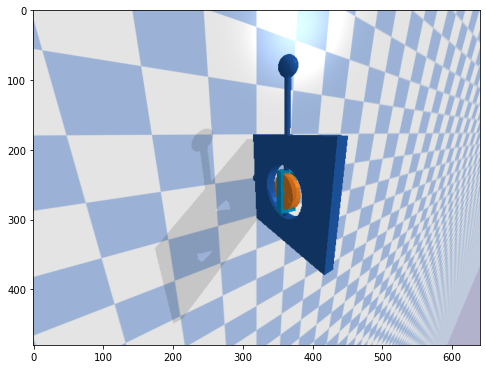

In [18]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

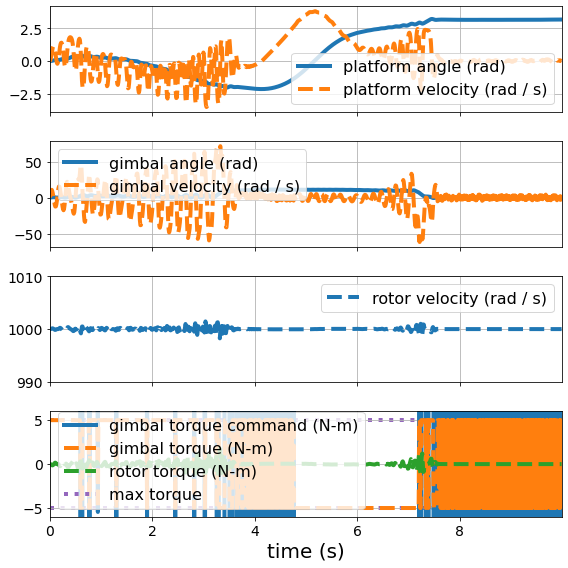

In [19]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_platform, ax_gimbal, ax_rotor, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot platform angle and velocity
ax_platform.plot(
    data['t'], data['platform_angle'],
    label='platform angle (rad)', linewidth=4,
)
ax_platform.plot(
    data['t'], data['platform_velocity'],
    '--', label='platform velocity (rad / s)', linewidth=4,
)
ax_platform.grid()
ax_platform.legend(fontsize=16)
ax_platform.tick_params(labelsize=14)

# Plot gimbal angle and velocity
ax_gimbal.plot(
    data['t'], data['gimbal_angle'],
    label='gimbal angle (rad)', linewidth=4,
)
ax_gimbal.plot(
    data['t'], data['gimbal_velocity'],
    '--', label='gimbal velocity (rad / s)', linewidth=4,
)
ax_gimbal.grid()
ax_gimbal.legend(fontsize=16)
ax_gimbal.tick_params(labelsize=14)

# Plot rotor velocity
ax_rotor.plot(
    data['t'], data['rotor_velocity'],
    '--', label='rotor velocity (rad / s)', linewidth=4,
)
ax_rotor.grid()
ax_rotor.legend(fontsize=16)
ax_rotor.tick_params(labelsize=14)
ax_rotor.set_ylim(simulator.rotor_velocity - 10., simulator.rotor_velocity + 10.)

# Plot torques
ax_torque.plot(
    data['t'], data['gimbal_torque_command'],
    label='gimbal torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['gimbal_torque'],
    '--', label='gimbal torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['rotor_torque'],
    '--', label='rotor torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', label='max torque', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [20]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)